In [1]:
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
import pandas as pd
import copy
import matplotlib.pyplot as plt
import time 

# k-fold cross validation


In this notebook you will use K-fold cross validation to compare two regression models. The two models are Kernel Ridge Regression and Regression Decision Trees. You don't need to understand how these two models work for now and can just use the provided fit_and_predict functions to get predictions for each of the models. 

The aim of this notebook is to practice K-fold cross validation. It is split into 5 parts:
1. Create a function to split the data into k folds 
2. Performance Metric - create a function to calculate RMSE
3. Create a function to run cross validation on the k-folds
4. Run cross validation for k={2, ..., 100}, timing each one 
5. Answer the questions in a markdown cell 

**NOTE: Make sure you restart the kernel and re-run the notebook just before you submit it so your answers are consistant. All the packages you need are already imported into the notebook, you should not use the sklearn k-fold cross validation functions.**



## Data

We will use a sklearn toy dataset. The input values for this dataset are ten baseline variables measured in diabetes patients and the output is a quantitative measure of disease progression one year later. You can read more about the data [here](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset).

In [2]:
# Do not edit this cell 

X_, y_ = load_diabetes(return_X_y=True)

# standardise the data to help us fit the data (this will be covered later in the course)

scaler = preprocessing.StandardScaler().fit(X_)
X = scaler.transform(X_)[:300, :]

scaler_y = preprocessing.StandardScaler().fit(y_.reshape(-1, 1))
y = scaler_y.transform(y_.reshape(-1, 1))[:300, :]
print(y.shape)

# to ensure the data stays in the correct order, we will work with dataframes 

columns = [f'x_{i}' for i in range(X.shape[1])] + ['y']
x_columns = [f'x_{i}' for i in range(X.shape[1])]
data = pd.DataFrame(data= np.concatenate([X, y.reshape(-1, 1)], axis=1), columns=columns)
print(data.head())

(300, 1)
        x_0       x_1       x_2       x_3       x_4       x_5       x_6  \
0  0.800500  1.065488  1.297088  0.459840 -0.929746 -0.732065 -0.912451   
1 -0.039567 -0.938537 -1.082180 -0.553511 -0.177624 -0.402886  1.564414   
2  1.793307  1.065488  0.934533 -0.119218 -0.958674 -0.718897 -0.680245   
3 -1.872441 -0.938537 -0.243771 -0.770658  0.256292  0.525397 -0.757647   
4  0.113172 -0.938537 -0.764944  0.459840  0.082726  0.327890  0.171178   

        x_7       x_8       x_9         y  
0 -0.054499  0.418551 -0.370989 -0.014719  
1 -0.830301 -1.436551 -1.938479 -1.001659  
2 -0.054499  0.060207 -0.545154 -0.144580  
3  0.721302  0.477072 -0.196823  0.699513  
4 -0.054499 -0.672582 -0.980568 -0.222496  


In [8]:
# Do not edit 

def fit_and_predict_KRR(train, validate):
    """fit a Kernel Ridge Regression Model on the training data and predict the y values of the validation X data.
    :param train: pandas dataframe containing the training data
    :param validate: pandas dataframe containing the validation data 
    :return: predictions at the validation X points Mx1 numpy array"""
    X_train = train[x_columns].to_numpy()
    y_train = train['y'].to_numpy()
    X_val = validate[x_columns].to_numpy()
        
    KRR = KernelRidge(alpha=0.1, kernel='rbf', gamma=0.2,  degree=100)
    KRR.fit(X_train, y_train)
    return KRR.predict(X_val)
    
    
def fit_and_predict_DT(train, validate):
    """fit a Regression Decision Tree on the training data and predict the y values of the validation X data.
    :param train: pandas dataframe containing the training data
    :param validate: pandas dataframe containing the validation data 
    :return: predictions at the validation X points Mx1 numpy array"""
    
    X_train = train[x_columns].to_numpy()
    y_train = train['y'].to_numpy()
    X_val = validate[x_columns].to_numpy()
        
    DTree = DecisionTreeRegressor(max_depth=6)
    DTree.fit(X_train, y_train)
    return DTree.predict(X_val)


## Part 1 : Creating the folds

### TO DO:

Complete the gaps to crete a function that split the data into k folds. 

**2 MARKS**

In [9]:

def k_folds(data, k):
    """function that returns a list of k folds of the data. The returned value should be a list of dataframes"""
    
    ############################
    # FILL YOUR ANSWERS HERE. Create list of how long each fold should be. The folds should be as even as possible in number, but some may
    # need to have an extra data point if the total number of data points isn't divisible by n
    num_samples = len(data)
    fold_size = num_samples // k
    remainder = num_samples % k
    
    len_folds = [fold_size] * k
    for i in range(remainder):
        len_folds[i] += 1
    
    ############################

    folds = []
    for i in range(k):
        data_ss = data.sample(n=len_folds[i], random_state=20)
        data = data.drop(data_ss.index)
        folds.append(data_ss)

    return folds 

In [10]:
folds = k_folds(data,5)
np.shape(folds)

(5, 60, 11)

## Part 2:  Performance Metric

### TO DO:
Write a function that calculates the root mean squared error between predictions and the true y values. Both inputs should be numpy arrays and the function should return a float. 

**1 MARK**

In [11]:
############################
# Write function to calculate RMSE

def calculate_rmse(predictions, true_values):
    """Calculate the root mean squared error (RMSE) between predictions and true y values.
    
    :param predictions: numpy array of predicted y values.
    :param true_values: numpy array of true y values.
    :return: float representing the RMSE.
    """
    mse = np.mean((predictions - true_values) ** 2)
    rmse = np.sqrt(mse)
    return rmse

    
############################

## Part 3: Cross Valiation

### TO DO:

Create a function to run the cross validation on both the models by filling out the gaps in the function below. This function will return the average RMSE for each of the models. 

**6 MARKS**


In [12]:
from sklearn.model_selection import train_test_split
def cross_validation(folds):
    """function that runs cross validation on k folds and returns the RMSE for each model"""
    folds = copy.copy(folds) # this creates a new variable which is a copy of folds

    rmses_KRR = []  # list to collect the rmses for each fold for the Kernel Ridge Regression
    rmses_DT = []   # list to collect the rmses for each fold for the Decision Tree
    for i, fold in enumerate(folds):
        
        ############################
        # Write code to create the training and validation sets as DataFrames
        
        train_data, val_data = train_test_split(fold, test_size=0.20, random_state=1)
        
        ############################
        
        ############################
        # Use the fit_and_predict functions to create new columns in the validation set for the predictions 
        # for each model with headings ['KRR_predictions', 'DT_predictions'].
        
        KRR_Predictions = fit_and_predict_KRR(train_data,val_data)
        DT_Predictions = fit_and_predict_DT(train_data,val_data)
        
        
        ############################
        
        ############################
        # calculate the rmse for the two models and append to rmses_KRR and rmses_DT
        rmses_KRR.append(calculate_rmse(KRR_Predictions,val_data['y'].to_numpy()))
        rmses_DT.append(calculate_rmse(DT_Predictions,val_data['y'].to_numpy()))
       
        
        ############################

    RMSE_KRR = np.mean(rmses_KRR) # calculate the average RMSEs for kernel ridge regression
    RMSE_DT = np.mean(rmses_DT)# calculate the average RMSEs for the decision tree 
    return RMSE_KRR, RMSE_DT


### TO DO: 
Use your functions to calculate the RMSE for each model for k=100 and print the solutions 

**2 MARKS**

In [13]:
############################
# calculate RMSE for each model for k=100



RMSE_KRR, RMSE_DT=cross_validation(k_folds(data,100))

############################

## Part 4: Cross Validation for Different Values of k

### TO DO:

for k in {2, ..., 100} divide the data into k folds and then run cross validation. Save the results for each run in two lists (one for each model) and then plot a graph of k on the x-axis and RMSE on the y_axis. 

Use the time function (example in cell below) to time how long the cross validation takes for each value of k. Make a plot of the time against the value of k. 

**6 MARKS**

In [14]:
# time function example

start = time.time()
print('hello')
end = time.time()
time_elapsed = end - start
print(time_elapsed)

hello
0.0


In [15]:
############################
# for k in {2, ..., 100} divide the data into k folds and then run cross validation. time it and plot results. 
KRR_RMSE_FOLDS ={}
DT_RMSE_FOLDS ={}
TIME_FOLDS = {}
for k in range(2,101):
    start = time.time()
    RMSE_KRR, RMSE_DT=cross_validation(k_folds(data,k))
    end = time.time()
    time_elapsed = end - start
    TIME_FOLDS[k] = time_elapsed
    KRR_RMSE_FOLDS[k] = RMSE_KRR 
    DT_RMSE_FOLDS[k]  = RMSE_DT    
        
############################'

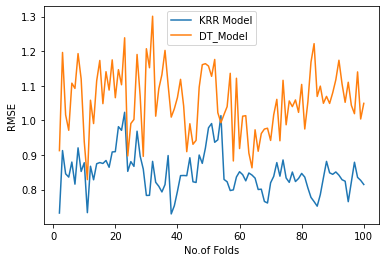

In [16]:
plt.plot(range(2,101),KRR_RMSE_FOLDS.values(), label='KRR Model')
plt.plot(range(2,101),DT_RMSE_FOLDS.values(), label='DT_Model')
plt.xlabel('No.of Folds')
plt.ylabel('RMSE')
plt.legend()
plt.show()

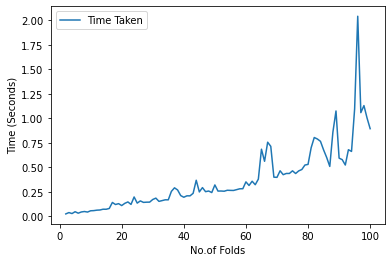

In [17]:
plt.plot(range(2,101),TIME_FOLDS.values(), label='Time Taken')
plt.xlabel('No.of Folds')
plt.ylabel('Time (Seconds)')
plt.legend()
plt.show()

## Part 5 : Questions

### TO DO:
Answer the following questions in a markdown cell

1. Which model would you select based on your cross validation results? Why? 
2. Looking at the two plots you made, what are the benefits and drawbacks of increasing k? 

**2 MARKS**

### WRITE YOUR ANSWERS HERE:

1. The model that I would select is the Kernel Ridge Regression Model as it has the least RMSE when compared to the DT Model. The number of K-folds I will choose is 38 as it shows the least RMSE when compared to other folds.
2. The drawbacks of increasing the number of folds is that it increases the time taken for computation and hence the computation cost. The benefits include a more representative data that is well suited to unknown data as it has higher representability.